# Configuración del notebook

In [ ]:
#@title #Configuración del notebook

#@markdown ##Envío de datos por telegram
send_telegram = True#@param {type:"boolean"}   
#@markdown ###Telegram ID 
#@markdown 507673519 -> id pública (https://t.me/joinchat/EdijlVvAWLUxMGQ0) \
#@markdown 4170424 -> Fran Arenas 
telegram_id = '4170424' #@param ["507673519", "4170424"] {allow-input: true}
#@markdown ---
#@markdown ##Descarga local de los datos
download_csv = False#@param {type:"boolean"} 
#@markdown ---
#@markdown ##Selección de modelos a entrenar

#@markdown ###XGBoost:
xgb = True#@param {type:"boolean"}  
#@markdown ###Decision Tree:
dt = True#@param {type:"boolean"}   
#@markdown ###Multi Layer Perceptron (2 hidden layer):
mlp = True#@param {type:"boolean"}  
#@markdown ###K Nearest Neighbour:
knn = True#@param {type:"boolean"}  
#@markdown ###Random Forest:
rf = True#@param {type:"boolean"}    

#Columnas de las que queremos sacar la media de los shapley values por cada posible valor (solo discretas)
cols_impact = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',  'CNT_CHILDREN', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','YEARS_BIRTH','YEARS_EMPLOYED']


# Funciones auxiliares

In [ ]:
def validation_matrix(labels_real,labels_pred):
  real_0_pred_0 = 0
  real_0_pred_1 = 0
  real_1_pred_0 = 0
  real_1_pred_1 = 0

  for i in range(len(labels_real)):
    if labels_real[i] == 0 and labels_pred[i] == 0:
      real_0_pred_0+=1
    elif labels_real[i] == 0 and labels_pred[i] == 1:
      real_0_pred_1+=1
    elif labels_real[i] == 1 and labels_pred[i] == 0:
      real_1_pred_0+=1
    else:
      real_1_pred_1+=1

  return [[real_0_pred_0,real_0_pred_1],[real_1_pred_0,real_1_pred_1]]
      

def plot_confusion_matrix(values,pred):

  matrix = validation_matrix(values,pred)

  fig, ax1= plt.subplots(1, sharex = True, sharey = False)
  ax1.imshow(matrix, interpolation ='none', aspect = 'auto')
  for (j,i),value in np.ndenumerate(matrix):
      ax1.text(i,j,value,ha='center',va='center')

  plt.show()

def take_higher_and_lower_values(array, n_values):
  index = np.argsort(array)

  high_index = index[0:n_values]
  low_index = index[-n_values:]

  values = np.sort(array)

  high_vals = values[0:n_values]
  low_vals = values[-n_values:]

  return [np.concatenate([high_vals,low_vals]),np.concatenate([high_index,low_index])]

def force_plot_func(X,excepted_value,shap_values, n_elements,element_index):
  values,index = take_higher_and_lower_values(shap_values[element_index,:],n_elements)
  shap.initjs()
  plt.figure(figsize=(200, 60), dpi=80)
  shap.force_plot(excepted_value, values, X.columns[index],matplotlib=True)

def print_variable_impact(shap_values,X,columns):
  for col,feature in enumerate(columns):
    impact = {}
    for unique in X[feature].unique():
      index = X[X[feature] == unique][feature].index
      mean = 0
      for i in index:
        mean += shap_values[i][col]
      mean = mean/len(index)
      impact[feature] = mean

      print("Feature: {}\t value: {}\t Impact: {}".format(feature,unique,mean))
    print("\n")

def variable_impact(shap_values,X,columns):
  impact = []
  for col,feature in enumerate(columns):
    for unique in X[feature].unique():
      index = X[X[feature] == unique][feature].index
      mean = 0
      for i in index:
        mean += shap_values[i][col]
      mean = mean/len(index)
      impact.append(mean)
  return impact

# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import datetime
!pip install shap
import shap

     |████████████████████████████████| 358kB 18.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491644 sha256=80e14103f6b607429004582fb6fe5753b348454a3b483e98ec5e1153ac1ab320
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


# Carga de datos

In [ ]:
csv_1 = pd.read_csv("https://raw.githubusercontent.com/FranArenas/Fran_Arenas_XAI_credit_card/main/data/application_record/csv_1.csv")
csv_2 = pd.read_csv("https://raw.githubusercontent.com/FranArenas/Fran_Arenas_XAI_credit_card/main/data/application_record/csv_2.csv")
csv_3 = pd.read_csv("https://raw.githubusercontent.com/FranArenas/Fran_Arenas_XAI_credit_card/main/data/application_record/csv_3.csv")
df_approval = pd.concat([csv_1,csv_2,csv_3], axis = 0)
df_credit = pd.read_csv("https://raw.githubusercontent.com/FranArenas/Fran_Arenas_XAI_credit_card/main/data/credit_record.csv")

MONTHS_BALANCE : tiempo, en meses, que ha transcurrido desde la extracción de la información. 0 este mes, 1 hace un mes, etc.

Status:
  - 0: 1-29 días de retraso
  - 1: 30-59 días de retraso
  - 2: 60-89 días de retraso
  - 3: 90-119 días de retraso
  - 4: 120-149 días de retraso
  - 5: Deudas insostenibles, cancelación 
  - C: Deudas pagadas ese mes
  - X: Sin deudas ese mes


In [ ]:
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# Creación de dataset principal

## Modificacion del dataset de crédito

Modificaremos los valores de STATUS X y C canviándolos por 0. De esta manera ampliaremos la categoría cero a "Sin deuda o con deuda inferior a 30 días". De esta manera todas nuestras variables serán numéricas






In [ ]:
df_credit["STATUS"] = df_credit["STATUS"].replace(["X"],0)
df_credit["STATUS"] = df_credit["STATUS"].replace(["C"],0)

df_credit["STATUS"] = df_credit["STATUS"].apply(pd.to_numeric) #Pasamos a tipo numércio


Para cada cliente (ID) seleccionamos su STATUS más elevado considerando este valor como su **factor de riesgo** (Varaible a predecir)




In [ ]:
df_credit = df_credit.groupby("ID")["STATUS"].max().reset_index()

In [ ]:
df_credit.head()

,ID,STATUS
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0


## Fusión de los dos datasets

In [ ]:
df = pd.merge(df_approval, df_credit, left_on = "ID", right_on= "ID")

df.shape

(36457, 19)

# EDA

In [ ]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


# Rango de valores por cada varaible

In [ ]:
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'STATUS'],
      dtype='object')

In [ ]:
for col in df.columns:
  if df[col].dtype == object:
    print("Feature: {}\t valores: {}".format(col,df[col].unique()))
  else:
    print("Feature: {}\t valores: {} to {}".format(col,min(df[col]),max(df[col])))

Feature: ID	 valores: 5008804 to 5150487
Feature: CODE_GENDER	 valores: ['M' 'F']
Feature: FLAG_OWN_CAR	 valores: ['Y' 'N']
Feature: FLAG_OWN_REALTY	 valores: ['Y' 'N']
Feature: CNT_CHILDREN	 valores: 0 to 19
Feature: AMT_INCOME_TOTAL	 valores: 27000.0 to 1575000.0
Feature: NAME_INCOME_TYPE	 valores: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
Feature: NAME_EDUCATION_TYPE	 valores: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Feature: NAME_FAMILY_STATUS	 valores: ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
Feature: NAME_HOUSING_TYPE	 valores: ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
Feature: DAYS_BIRTH	 valores: -25152 to -7489
Feature: DAYS_EMPLOYED	 valores: -15713 to 365243
Feature: FLAG_MOBIL	 valores: 1 to 1
Feature: FLAG_WORK_PHONE	 valores: 0 to 1
Feature: FLAG_PHONE	 valores: 0 to 1
F

## Distribución de variables de mayor interés

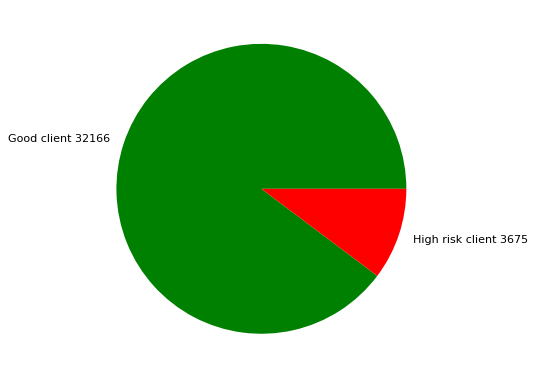

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
clients = [df['STATUS'][df['STATUS'] == 0].shape[0],df['STATUS'][df['STATUS'] == 1].shape[0]]
plt.pie(clients, labels= ["Good client {}".format(clients[0]), "High risk client {}".format(clients[1])], colors= ["green","red"]);

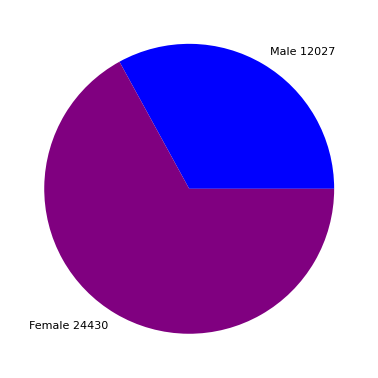

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
code_gender = [df['CODE_GENDER'][df['CODE_GENDER'] == 'M'].shape[0],df['CODE_GENDER'][df['CODE_GENDER'] == 'F'].shape[0]]
plt.pie(code_gender, labels= ["Male {}".format(code_gender[0]), "Female {}".format(code_gender[1])], colors= ["blue","purple"]);

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 1.0, 'OCCUPATION_TYPE')

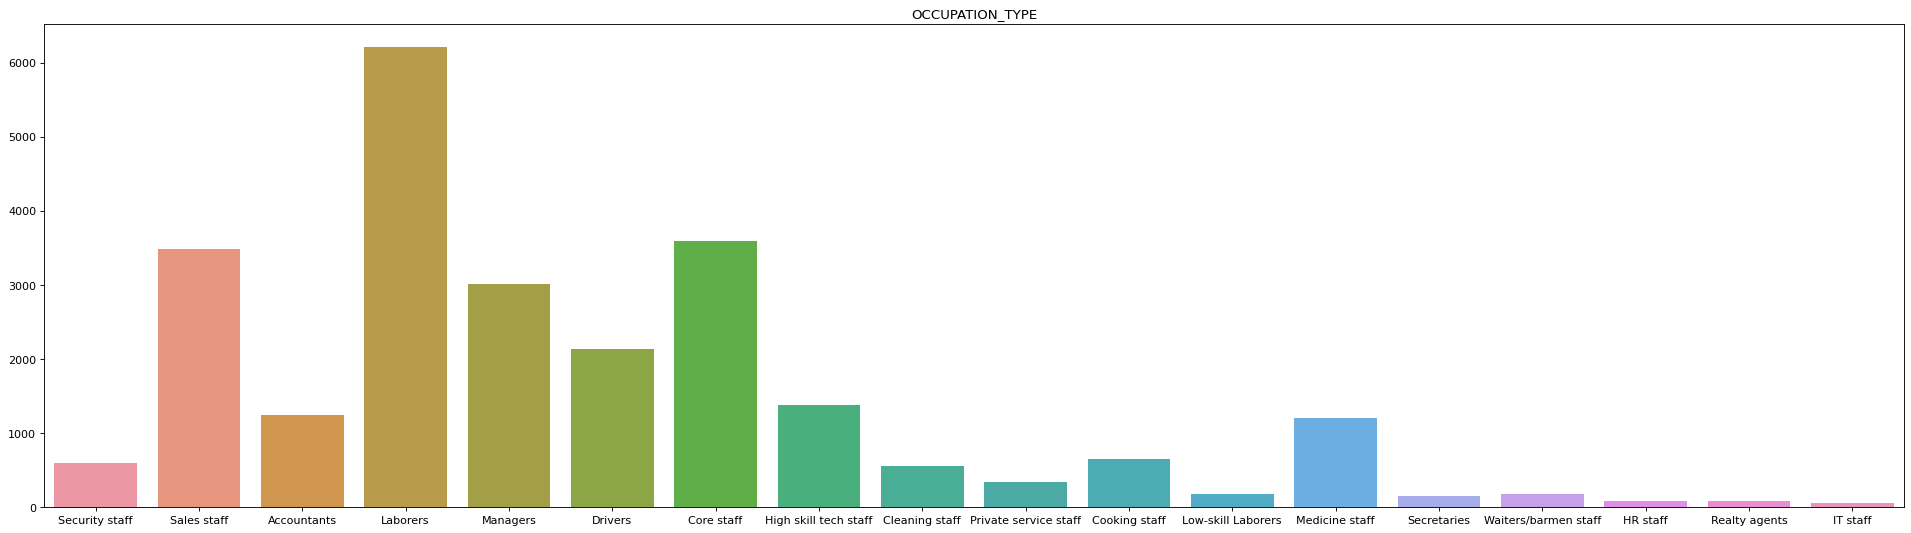

In [ ]:
plt.figure(figsize=(30, 8), dpi=80)

jobs = df['OCCUPATION_TYPE'].unique()
job_count = []

for job in jobs:
  job_count.append(df['OCCUPATION_TYPE'][df['OCCUPATION_TYPE'] == job].shape[0])

sns.barplot(jobs,job_count).set_title("OCCUPATION_TYPE")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 1.0, 'NAME_EDUCATION_TYPE')

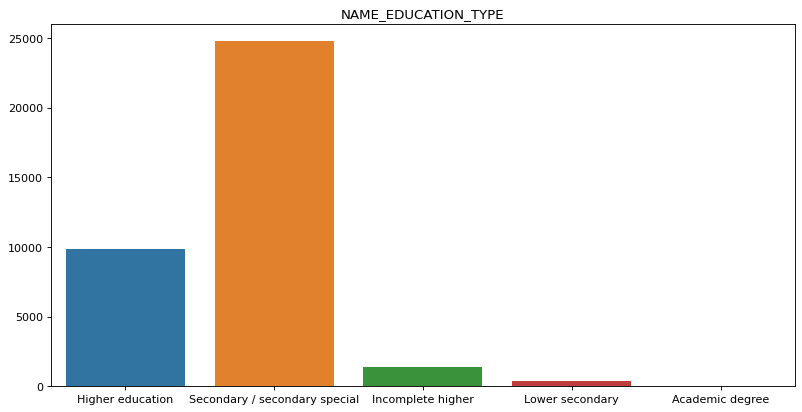

In [ ]:
plt.figure(figsize=(12, 6), dpi=80)

jobs = df['NAME_EDUCATION_TYPE'].unique()
job_count = []

for job in jobs:
  job_count.append(df['NAME_EDUCATION_TYPE'][df['NAME_EDUCATION_TYPE'] == job].shape[0])

sns.barplot(jobs,job_count).set_title("NAME_EDUCATION_TYPE")

# Limpieza de datos

In [ ]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


Convertimos la variable a predecir en una  varaible binaria

In [ ]:
df["bad_client"] = np.where(df["STATUS"] < 1 , 0,1)

df.drop("STATUS", axis = 1, inplace = True)

In [ ]:
df[df["bad_client"] == 1]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,bad_client
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
18,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0,1
19,5008826,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0,1
20,5008830,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,1


Eliminamos la variable ID

In [ ]:
df.drop("ID", axis = 1, inplace = True)

## Valores nulos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          36457 non-null  object 
 1   FLAG_OWN_CAR         36457 non-null  object 
 2   FLAG_OWN_REALTY      36457 non-null  object 
 3   CNT_CHILDREN         36457 non-null  int64  
 4   AMT_INCOME_TOTAL     36457 non-null  float64
 5   NAME_INCOME_TYPE     36457 non-null  object 
 6   NAME_EDUCATION_TYPE  36457 non-null  object 
 7   NAME_FAMILY_STATUS   36457 non-null  object 
 8   NAME_HOUSING_TYPE    36457 non-null  object 
 9   DAYS_BIRTH           36457 non-null  int64  
 10  DAYS_EMPLOYED        36457 non-null  int64  
 11  FLAG_MOBIL           36457 non-null  int64  
 12  FLAG_WORK_PHONE      36457 non-null  int64  
 13  FLAG_PHONE           36457 non-null  int64  
 14  FLAG_EMAIL           36457 non-null  int64  
 15  OCCUPATION_TYPE      25134 non-null 

Vemos que la única variable con valores nulos es OCCUPATION_TYPE. Como es una variable interesante para ver posibles sesgos, primeramente eliminaremos todas las filas que tengan esta variable nula. En caso de que no tenga un impacto relevante en el modelo final se podrá reentrenar el modelo eliminando esta columna y añadiendo los valores eliminados

In [ ]:
df = df.dropna().reset_index()

## DAYS_BIRTH	DAYS_EMPLOYED
Cambio de días transcurridos a años transcurridos

In [ ]:
from math import floor

In [ ]:
df["DAYS_BIRTH"].map(lambda x: floor(-x/365))

0        58
1        52
2        52
3        52
4        52
         ..
25129    47
25130    33
25131    33
25132    49
25133    25
Name: DAYS_BIRTH, Length: 25134, dtype: int64

In [ ]:
df["YEARS_BIRTH"] = df["DAYS_BIRTH"].map(lambda x: floor(-x/365))
df["YEARS_EMPLOYED"] = df["DAYS_EMPLOYED"].map(lambda x: floor(-x/365))

df.drop(labels = ["DAYS_BIRTH", "DAYS_EMPLOYED"], axis = 1,  inplace = True)

In [ ]:
df.head()

,index,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,bad_client,YEARS_BIRTH,YEARS_EMPLOYED
0,2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,58,3
1,3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8
2,4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8
3,5,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8
4,6,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52,8


## Codificación para el modelo

Los datos no han sido codificados usando One Hot Encoding debido a que la explicabilidad es más sencilla si se codifica de manera ordinal. Independientemente, los resultados de la predicción no han mejorado notablemente utilizando One Hot

In [ ]:
df.head()

df_cat = df.copy()

dct_CODE_GENDER = {'M':1, 'F':0}
dct_yes_no = {'Y':1,'N':0}
dct_NAME_INCOME_TYPE = {'Working': 0, 'Commercial associate': 1, 'State servant': 2, 'Student': 3,'Pensioner': 4}
dct_NAME_EDUCATION_TYPE = {'Secondary / secondary special': 0, 'Higher education':1,'Incomplete higher':2, 'Lower secondary':3, 'Academic degree':4}
dct_NAME_FAMILY_STATUS = {'Married':0, 'Single / not married':1, 'Civil marriage':2, 'Separated':3,'Widow':4}
dct_NAME_HOUSING_TYPE = {'House / apartment':0, 'Rented apartment':1, 'Municipal apartment':2,'With parents':3, 'Co-op apartment':4, 'Office apartment':5}
dct_OCCUPATION_TYPE = {'Security staff':0, 'Sales staff':1, 'Accountants':2, 'Laborers':3,'Managers':4, 'Drivers':5, 'Core staff':6, 'High skill tech staff':7,'Cleaning staff':8, 'Private service staff':9, 'Cooking staff':10,'Low-skill Laborers':11, 'Medicine staff':12, 'Secretaries':13,'Waiters/barmen staff':14, 'HR staff':15, 'Realty agents':16, 'IT staff':17}

df_cat['CODE_GENDER'] = df_cat['CODE_GENDER'].map(dct_CODE_GENDER)
df_cat['FLAG_OWN_CAR'] = df_cat['FLAG_OWN_CAR'].map(dct_yes_no)
df_cat['FLAG_OWN_REALTY'] = df_cat['FLAG_OWN_REALTY'].map(dct_yes_no)
df_cat['NAME_INCOME_TYPE'] = df_cat['NAME_INCOME_TYPE'].map(dct_NAME_INCOME_TYPE)
df_cat['NAME_EDUCATION_TYPE'] = df_cat['NAME_EDUCATION_TYPE'].map(dct_NAME_EDUCATION_TYPE)
df_cat['NAME_FAMILY_STATUS'] = df_cat['NAME_FAMILY_STATUS'].map(dct_NAME_FAMILY_STATUS)
df_cat['NAME_HOUSING_TYPE'] = df_cat['NAME_HOUSING_TYPE'].map(dct_NAME_HOUSING_TYPE)
df_cat['OCCUPATION_TYPE'] = df_cat['OCCUPATION_TYPE'].map(dct_OCCUPATION_TYPE)

In [ ]:
df_cat.head()

,index,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,bad_client,YEARS_BIRTH,YEARS_EMPLOYED
0,2,1,1,1,0,112500.0,0,0,0,0,1,0,0,0,0,2.0,0,58,3
1,3,0,0,1,0,270000.0,1,0,1,0,1,0,1,1,1,1.0,0,52,8
2,4,0,0,1,0,270000.0,1,0,1,0,1,0,1,1,1,1.0,0,52,8
3,5,0,0,1,0,270000.0,1,0,1,0,1,0,1,1,1,1.0,0,52,8
4,6,0,0,1,0,270000.0,1,0,1,0,1,0,1,1,1,1.0,0,52,8


In [ ]:
df_cat.drop("FLAG_MOBIL", axis = 1, inplace = True) #Observamos que todos los valores son 1
df_cat.drop("index", axis = 1, inplace = True) #Observamos que todos los valores son 1

In [ ]:
df_cat.shape

(25134, 17)

## Train Test split

In [ ]:
##from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df_cat.copy()
y = X.pop("bad_client")



X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                     test_size=0.2,
                                                    random_state = 186)





# Modelo:  XGBoost (tree based model)

In [ ]:
from sklearn.model_selection import  RandomizedSearchCV 
from sklearn.metrics import confusion_matrix
from time import time
from xgboost import XGBClassifier,plot_importance
import matplotlib.pylab as plb


## Training

---

In [ ]:
if xgb:
  shap.initjs()

  model_xgb = XGBClassifier(max_depth= 8,
                      n_estimators=600, #Para mejor resultados con 2000 pero incrementa mucho el coste computacional
                      min_child_weight=8, 
                      subsample=0.8, 
                      learning_rate =0.035,    
                      seed=7429,
                      scale_pos_weight=len(y_train[y_train == 0])/len(y_train[y_train == 1]),
                      predictor='gpu_predictor')
    
  model_xgb.fit(X_train, y_train)

  pred = model_xgb.predict(X_test)

  plot_confusion_matrix(y_test.to_numpy(),pred) 

  #Dependiendo de la cantadidad de árboles usado en nuestro modelo puede tardar una cantidad de tiempo elevada
  explainer_xgboost = shap.TreeExplainer(model_xgb)
  shap_values_xgboost = explainer_xgboost.shap_values(X)

  #SHAP plots
  force_plot_func(X,explainer_xgboost.expected_value,shap_values_xgboost,3,113)

  shap.force_plot(explainer_xgboost.expected_value, shap_values_xgboost[:2000,:], X.iloc[:2000,:])

  shap.summary_plot(shap_values_xgboost, X, plot_type="bar")

  shap.summary_plot(shap_values_xgboost, X)

  for name in X_train.columns:
    shap.dependence_plot(name, shap_values_xgboost, X, display_features=X)

  print_variable_impact(shap_values_xgboost,X,cols_impact)


# Modelo: Decision Tree (Transparente)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
if dt:
  shap.initjs()

  tree_model = DecisionTreeClassifier()

  tree_model.fit(X_train,y_train)

  predict = tree_model.predict(X_test)

  plot_confusion_matrix(y_test.to_numpy(),predict)

  #Calculate shapley values
  tree_explainer = shap.TreeExplainer(tree_model)
  shap_values_tree_both = tree_explainer.shap_values(X)
  shap_values_tree = []
  for i,val in enumerate(tree_model.predict(X)):
    shap_values_tree.append(shap_values_tree_both[val][i])

  #Plot for one prediction
  shap.force_plot(tree_explainer.expected_value[0], shap_values_tree[299], X.iloc[299,:])

# Modelo: Multi Layer Perceptron

In [ ]:
if mlp:
  import tensorflow as tf
  !pip install tensorflow-addons
  import tensorflow_addons as tfa
  from sklearn.model_selection import KFold
  from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
  from keras import metrics as mtr

In [ ]:
if mlp:
  def create_mlp(input_size,hidden_units,dropout_rate,learning_rate):
    """
    Crea un modelo Multilayer Perceptron

    Parameters:

    input_size (int): tamaño de la capa de entrada
    hidden_units (int[]): array que contiene el número de neuronas por capa oculta, a más elementos más capas ocultas
    dropout_rate (float): ratio de dropout
    learning_rate (float): ratio de aprendizaje

    """
    #Input
    inp = tf.keras.layers.Input(shape = (input_size,))
    x = tf.keras.layers.BatchNormalization()(inp)

    for units in hidden_units:
      x =  tfa.layers.WeightNormalization(tf.keras.layers.Dense(units,activation = 'relu'))(x)
      x = tf.keras.layers.Dropout(dropout_rate)(x)
      x = tf.keras.layers.BatchNormalization()(x)

    out = tfa.layers.WeightNormalization(tf.keras.layers.Dense(1, activation = 'sigmoid'))(x)

    model = tf.keras.models.Model(inputs = inp, outputs = out)

    model.compile(optimizer = tfa.optimizers.Lookahead(tf.optimizers.Adam(learning_rate), sync_period = 10),
                  loss = "binary_crossentropy")
    
    return model

## Training

### Entrenamiento

In [ ]:
if mlp:

  #Validation data

  X_tr,X_val,y_tr,y_val = train_test_split(X_train, y_train, test_size = 0.25)

  hidden_units = [1024*2,1024*2]
  dropout_rate = 0.4
  learning_rate = 0.0022
  size = len(X_train.columns)

  weights = {0:1,1:len(y_train[y_train == 0])/len(y_train[y_train == 1])-2.25}


  start_time = time()

  #Model creation
  model = create_mlp(size, hidden_units, dropout_rate, learning_rate)

  #Model fit
  history = model.fit(X_tr, y_tr, 
                      validation_data = (X_val, y_val), 
                      epochs = 250, 
                      batch_size = 64, 
                      verbose = 1,
                      class_weight = weights)

  hist = pd.DataFrame(history.history)

  predict = np.around(model.predict(X_test))

  plot_confusion_matrix(y_test.to_numpy(),predict)



## One prediction explain

In [ ]:
if mlp:

  shap.initjs()
  explainer_mlp = shap.KernelExplainer(model,shap.sample(X, 5,random_state=2233))
  shap_values_mlp = explainer_mlp.shap_values(X, nsamples=500)

  shap.force_plot(explainer_mlp.expected_value, shap_values_mlp[0][9], X.iloc[9,:])

## Multiple prediction explain

In [ ]:
if mlp:

  shap.initjs()
  shap_values50 = explainer_mlp.shap_values(X.iloc[280:330,:], nsamples=500)
  shap.force_plot(explainer_mlp.expected_value, shap_values50[0], X.iloc[280:330,:])

# Modelo KNN

In [ ]:
if knn:
  from sklearn.neighbors import KNeighborsClassifier
  from imblearn.over_sampling import SMOTE
  from collections import Counter

In [ ]:
if knn:

  oversample = SMOTE(ratio= 'not majority')
  X_ts, y_ts = oversample.fit_resample(X_train, y_train)

  knn_classifier = KNeighborsClassifier(n_neighbors=3)

  knn_classifier.fit(X_ts, y_ts)

  pred_knn = knn_classifier.predict(X_test)
  plot_confusion_matrix(y_test.to_numpy(),pred_knn)

  explainer_knn = shap.KernelExplainer(knn_classifier.predict,shap.sample(X, 5,random_state=2233))
  shap_values_knn = explainer_knn.shap_values(X, nsamples = 750)

# Modelo Random forest

In [ ]:
if rf:
  from sklearn.ensemble import RandomForestClassifier

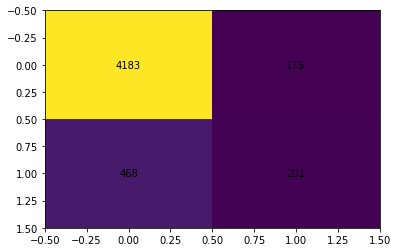

In [ ]:
if rf:
  rf_classifier = RandomForestClassifier(class_weight='balanced')

  rf_classifier.fit(X_train, y_train)

  pred_rf = rf_classifier.predict(X_test)
  plot_confusion_matrix(y_test.to_numpy(),pred_rf)

  explainer_rf = shap.TreeExplainer(rf_classifier)
  shap_values_rf_both = explainer_rf.shap_values(X)

  shap_values_rf = []
  for i,val in enumerate(rf_classifier.predict(X)):
    shap_values_rf.append(shap_values_rf_both[val][i])

In [ ]:
shap_values_rf_a = []
for i,val in enumerate(Rf_classifier.predict(X)):
  shap_values_rf_a.append(shap_values_rf[val][i])

# Descarga de los resultados

In [ ]:
all_values_names = []
for col,feature in enumerate(cols_impact):
  for unique in X[feature].unique():
    all_values_names.append("{}_{}".format(feature,unique))

all_values_names.append("MODEL")

In [ ]:
if download_csv or send_telegram:
  #Dataset of mean shapvalues for model
  send_models = []

  if xgb:
    shap_mean_xgboost = np.append(variable_impact(shap_values_xgboost, X, cols_impact),"xgboost")
    send_models.append(shap_mean_xgboost)
  if dt:
    shap_mean_dt = np.append(variable_impact(shap_values_tree, X, cols_impact),"DT")
    send_models.append(shap_mean_dt)
  if mlp:
    shap_mean_mlp = np.append(variable_impact(shap_values_mlp[0], X, cols_impact),"MLP")
    send_models.append(shap_mean_mlp)
  if knn:
    shap_mean_knn = np.append(variable_impact(shap_values_knn, X, cols_impact),"KNN")
    send_models.append(shap_mean_knn)
  if rf:
    shap_mean_rf = np.append(variable_impact(shap_values_rf, X, cols_impact),"RF")
    send_models.append(shap_mean_rf)

  send_dataset = pd.DataFrame(data= send_models,columns = all_values_names)

  #Dataset of shap values of every model
  if xgb:
    shap_values_xgboost_df = pd.DataFrame(shap_values_xgboost, columns =X.columns)
  if dt:
    shap_values_tree_df = pd.DataFrame(shap_values_tree, columns =X.columns)
  if mlp:
    shap_values_mlp_df = pd.DataFrame(shap_values_mlp[0], columns =X.columns)
  if knn:
    shap_values_knn_df = pd.DataFrame(shap_values_knn, columns = X.columns)
  if rf:
    shap_values_rf_df = pd.DataFrame(shap_values_rf, columns = X.columns)

ValueError: ignored

In [ ]:
if download_csv:

  send_dataset.download_csv()

  if xgb:
    shap_values_xgboost_df.download_csv()
  if dt:
    shap_values_tree_df.download_csv()
  if mlp:
    shap_values_mlp_df.download_csv()
  if knn:
    shap_values_knn_df.download_csv()
  if rf:
    shap_values_rf_df.download_csv()

## Enviar CSV a telegram

In [ ]:
if send_telegram:
  import requests

  def send_csv(df, id,name):
    files = {'document' : df.to_csv()}
    resp = requests.post('https://api.telegram.org/bot1731230204:AAHdcXkGLshJHO9nDgvW4ZJXj8JYa_WXhpc/sendDocument?chat_id=-{}&caption={}'.format(id,name),files=files)
    print(resp.status_code)

  send_csv(send_dataset,telegram_id,"Mean shap values modelos")

  if xgb:
    send_csv(shap_values_xgboost_df,telegram_id,"shap_values_xgboost_df")
  if dt:
    send_csv(shap_values_tree_df,telegram_id,"shap_values_tree_df")
  if mlp:
    send_csv(shap_values_mlp_df,telegram_id,"shap_values_mlp_df")
  if knn:
    send_csv(shap_values_knn_df,telegram_id,"shap_values_knn_df")
  if rf:
    send_csv(shap_values_rf_df,telegram_id,"shap_values_rf_df")

200
200
